# Time Series Data Cleaning
Note: this is a 'quick and dirty' heuristic-based cleaning. I did not label, classify, or use unsupervised anomaly detection methods here because I have extensive experience with similar sensor data and know the common, large-impact, or good value-to-fix problems.

The NREL-provided "clean" sonic data had uncomfortable inconsistencies, and I don't have the domain knowledge of sonic anemometers to adequately quality control them in a reasonable time frame. So I changed to my backup plan: use the 1Hz cup anemometer data instead of the problematic 20Hz sonic anemometer data.

**Goal:** At the end of cleaning, I need one good class-one cup anemometer time series: either Cup_WS_C1_130m or Cup_WS_C1_105m will work. Cup_WS_122m is a lower grade instrument that I included, like the rest of the variables,  only to aid the quality control process.

I've worked wtih cup anemometer data before, so I know the common problems to watch out for. In this notebook I'll screen for the following anomalies:
* dead instruments - long periods of 0s
* calibration changes and sensor drift - changes in linear correlation structure between related sensors
* data logger errors and electrical interference - spikes and out-of-range values
* ice buildup - causes flatlines and subtler issues
* "mast shadow" (when the wind hits the mounting tower (mast) before passing through the anemometer) - reduces measured speed by 30%-ish  and increases high frequency content, biasing my analysis.

This is not an exhaustive list of anomalies (there are always novel ones!), but it covers common, large-impact, or good value-to-fix problems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_rows = 15
pd.options.display.max_columns = 100

In [3]:
data_path = Path('../data/processed/cups_1hz.parquet')
assert data_path.exists()

In [4]:
onehz = pd.read_parquet(data_path).set_index('timestamp')

In [5]:
onehz = onehz.asfreq('1s') # fill mising timestamps with nan

In [6]:
onehz.head(3)

,Air_Temp_87m,DeltaT_122_87m,Dewpt_Temp_122m,Dewpt_Temp_87m,PRECIP_INTEN,Cup_WS_C1_130m,Cup_WS_122m,Cup_WS_C1_105m,Vane_WD_122m,Vane_WD_87m
timestamp,,,,,,,,,,
2018-12-31 17:00:00,-15.698145,-0.286780,-14.127690,-14.877580,2.939480,6.966611,7.332340,6.931492,22.893036,28.280596
2018-12-31 17:00:01,-15.555123,-0.286780,-14.108216,-14.851624,2.944349,7.140418,7.182121,6.859962,28.400145,23.877924
2018-12-31 17:00:02,-15.672141,-0.290412,-14.095233,-14.910026,2.911893,7.181488,6.682454,6.982190,27.367561,21.780317


In [7]:
onehz.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31536000 entries, 2018-12-31 17:00:00 to 2019-12-31 16:59:59
Freq: S
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Air_Temp_87m     float32
 1   DeltaT_122_87m   float32
 2   Dewpt_Temp_122m  float32
 3   Dewpt_Temp_87m   float32
 4   PRECIP_INTEN     float32
 5   Cup_WS_C1_130m   float32
 6   Cup_WS_122m      float32
 7   Cup_WS_C1_105m   float32
 8   Vane_WD_122m     float32
 9   Vane_WD_87m      float32
dtypes: float32(10)
memory usage: 1.4 GB


In [8]:
onehz.describe()

,Air_Temp_87m,DeltaT_122_87m,Dewpt_Temp_122m,Dewpt_Temp_87m,PRECIP_INTEN,Cup_WS_C1_130m,Cup_WS_122m,Cup_WS_C1_105m,Vane_WD_122m,Vane_WD_87m
count,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07,3.065500e+07
mean,8.970624e+00,-1.763525e-01,-1.918327e+00,-1.779006e+00,2.927026e+00,4.671487e+00,4.472371e+00,4.553857e+00,1.928816e+02,1.967486e+02
std,1.028146e+01,4.441290e-01,7.874010e+00,7.821231e+00,2.155974e-01,3.898527e+00,3.975269e+00,3.780641e+00,1.136525e+02,1.118034e+02
min,-2.123694e+01,-7.123314e+00,-2.179406e+01,-2.126939e+01,8.711027e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.558531e-02,5.312162e-03
25%,3.266798e-01,-3.470648e-01,-7.564864e+00,-7.428036e+00,2.963173e+00,2.068971e+00,1.967217e+00,2.066996e+00,8.989622e+01,1.008394e+02
50%,8.669248e+00,-2.552783e-01,-2.391200e+00,-2.210760e+00,2.968365e+00,3.669302e+00,3.541777e+00,3.582443e+00,1.934486e+02,2.035990e+02
75%,1.721289e+01,-1.040287e-01,3.905480e+00,4.044782e+00,2.972909e+00,6.122354e+00,5.890050e+00,5.890267e+00,2.924847e+02,2.943127e+02
max,3.315184e+01,9.393590e+00,3.546679e+01,2.625715e+01,3.024838e+00,4.196157e+01,4.349261e+03,4.462831e+01,3.599928e+02,3.599975e+02


## dead instruments - long periods of 0s
This check can be done on coarse aggregates and is easy to do visually. It could also be quantified by resampling/rolling with a period of 24 hours or more and testing for near-zero variance.

In [9]:
day_means = onehz.resample('1d').mean()

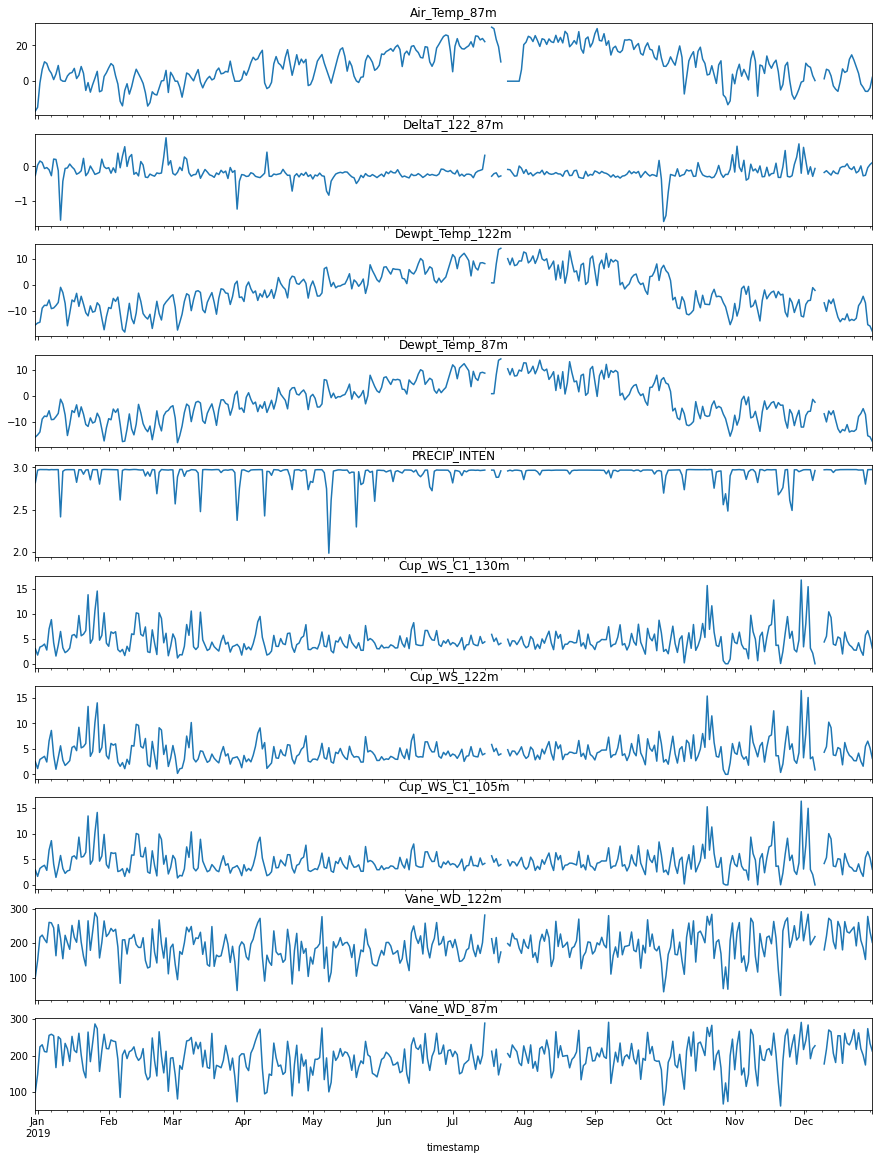

In [10]:
fig, axs = plt.subplots(nrows=len(day_means.columns), sharex=True, figsize=(15,20))
for i, col in enumerate(day_means.columns):
    day_means[col].plot(ax=axs[i])
    axs[i].set_title(col)

All instruments have plausible daily means for the entire year. I can rule out long-term instrument failures.

* ~~dead instruments - long periods of 0s~~

## calibration changes and sensor drift - changes in linear correlation structure between related sensors
This check can be done on aggregates because I'm looking at linear transformations (preserved through taking a mean). Gross changes can be spotted visually, but usually I'm looking for relative changes around 1%, which require changepoint detection techniques. I'll demonstrate each below.

**Background:** most sensors have linear transfer functions that convert the raw electrical signals into meaningful values. If a sensor is replaced, or recalibrated in a lab, or just mistakenly reprogrammed, this transfer function will change abruptly. The best source of info here is thorough maintenance documentation, but changepoint detection is a good way to verify.

Additionally, sensors drift over time as components wear and age. This manifests as gradual trends in the correlation coefficients.
* check for step changes and trends over time in linear regression coefficients vs similar sensor

In [11]:
# similar sensors (same type, different vertical location)
pairs = [('Dewpt_Temp_122m', 'Dewpt_Temp_87m'),
         ('Vane_WD_122m', 'Vane_WD_87m'),
         ('Cup_WS_C1_130m', 'Cup_WS_122m'),
         ('Cup_WS_C1_105m', 'Cup_WS_122m'),
         ('Cup_WS_C1_130m', 'Cup_WS_C1_105m'),
        ]

### Visual Analysis: Scatter plots colored by time
I'm looking for distinct lines with different colors

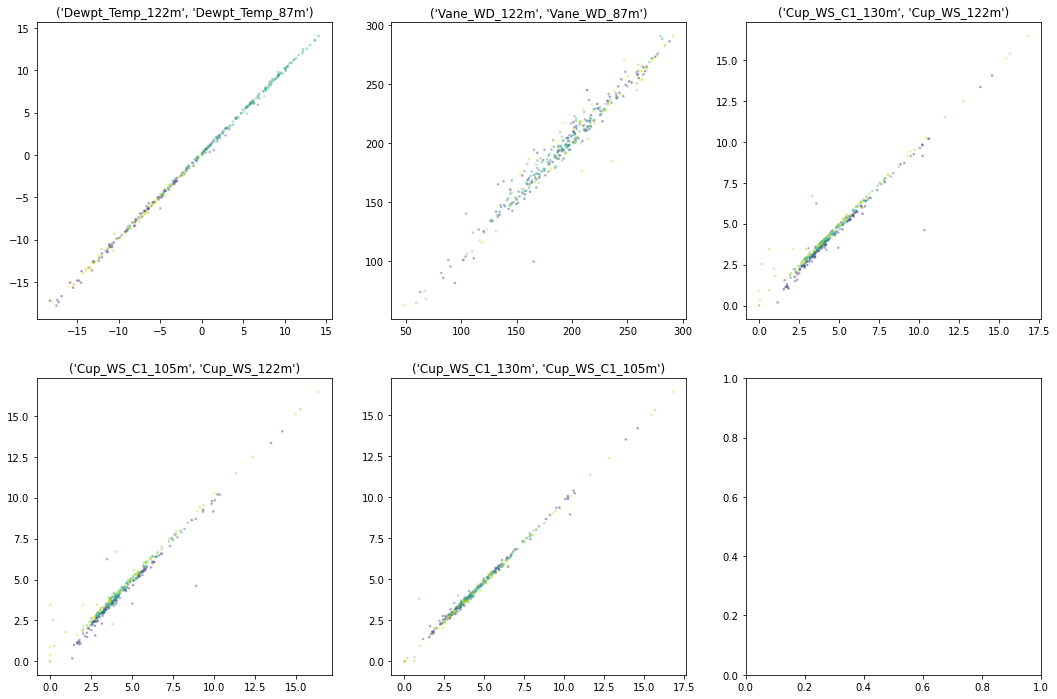

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18,12))
for i, pair in enumerate(pairs):
    axs[i//3, i%3].scatter(day_means[pair[0]], day_means[pair[1]], c=day_means.index, s=3, alpha=0.3)
    axs[i//3, i%3].set_title(str(pair))
plt.show()

The two plots involving 'Cup_WS_122m' show a green line slightly above a blue one. Because the 130m vs 105m correlation does NOT show this pattern, this is probably NOT exogenous seasonal variation in wind shear (how wind speed varies with height).

### Regression Coefficient Changepoint Detection
I'll take a closer look by performing changepoint detection: applying rolling linear regression and seeing how the coefficients change over time. At a previous job, I automated this exact detection and segmentation process with a linear parametric changepoint model. This is good for consistency of decision points. But this is a one-off so I'll do it manually here.

To make it easier to find step changes as well as trends, I'll use a robust regressor to better preserve sharp changes.

In [13]:
from statsmodels.api import RLM, add_constant

In [14]:
# no multi-column rolling functionality in pandas, so i have to make my own version.
def rolling_robust_linear(df, *, xcol, ycol, window_days=30, min_frac=0.8):
    """get rolling linear coeffs and their standard errors. Input df MUST have all time steps present, even if filled with NaN."""
    min_count = int(window_days * min_frac)
    data = df[[xcol, ycol]].to_numpy()
    not_null_indicator = ~np.any(np.isnan(data), axis=1)
    null_result = pd.DataFrame(np.full((1,4), np.nan, dtype=np.float64),
                                  columns=['intercept', 'slope', 'intercept_se', 'slope_se'])
    
    outputs=[]
    for i in range(len(data) - window_days):
        window = data[i:i+window_days]
        window = window[not_null_indicator[i:i+window_days]] # index by not_null removes null values
        if len(window) >= min_count:
            rlm = RLM(window[:,1], add_constant(window[:,0])).fit()  # API is y, x
            output = pd.DataFrame(np.concatenate([rlm.params, rlm.bse]).reshape(1,4),
                                  columns=['intercept', 'slope', 'intercept_se', 'slope_se'])
        else:
            output = null_result
        outputs.append(output)
    
    return pd.concat(outputs, ignore_index=True).set_index(df.index[window_days:])

In [15]:
roll = rolling_robust_linear(day_means, xcol='Cup_WS_C1_130m', ycol='Cup_WS_122m')
roll.sample(3)

,intercept,slope,intercept_se,slope_se
timestamp,,,,
2019-11-09,0.109990,0.973649,0.037852,0.006471
2019-04-23,-0.331116,1.005994,0.038444,0.008593
2019-05-09,-0.289921,1.006307,0.038217,0.008767


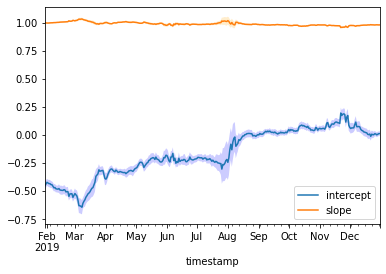

In [16]:
roll[['intercept', 'slope']].plot()
plt.fill_between(roll.index, roll['slope'] - roll['slope_se'], roll['slope'] + roll['slope_se'], alpha=0.2, facecolor='orange')
plt.fill_between(roll.index, roll['intercept'] - roll['intercept_se'], roll['intercept'] + roll['intercept_se'], alpha=0.2, facecolor='blue')

Intercept doesn't look good... hard to see slope on this scale.

In [17]:
# check other sensor pair
roll2 = rolling_robust_linear(day_means, xcol='Cup_WS_C1_130m', ycol='Cup_WS_C1_105m')

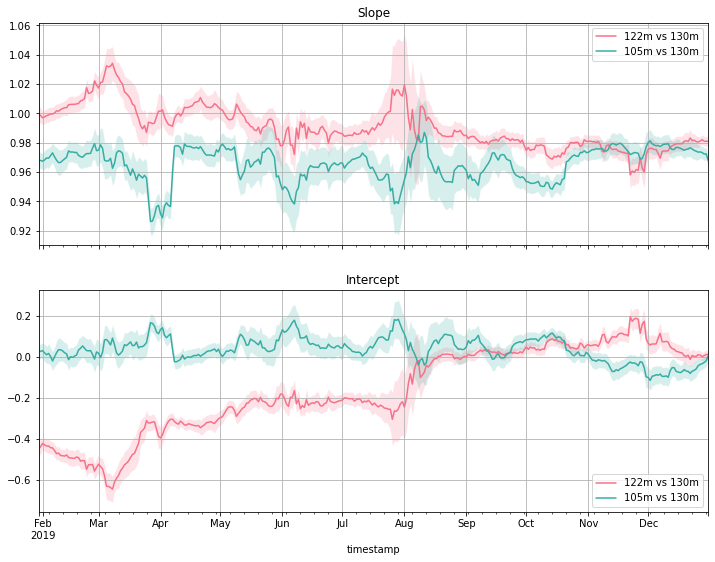

In [18]:
fix, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,9))
colors = sns.color_palette('husl', 2)
dfs= {'122m vs 130m': roll, '105m vs 130m': roll2}
with sns.axes_style("darkgrid"):
    for i, df in enumerate(dfs.values()):
        df['slope'].plot(ax=axs[0], c=colors[i], label=list(dfs.keys())[i])
        axs[0].fill_between(df.index, df['slope'] - df['slope_se'], df['slope'] + df['slope_se'], alpha=0.2, facecolor=colors[i])

        df['intercept'].plot(ax=axs[1], c=colors[i], label=list(dfs.keys())[i])
        axs[1].fill_between(df.index, df['intercept'] - df['intercept_se'], df['intercept'] + df['intercept_se'], alpha=0.2, facecolor=colors[i])
        
axs[0].set_title('Slope')
axs[1].set_title('Intercept')
axs[0].legend()
axs[1].legend()
plt.show()

**122m vs 130m (magenta) has clear changes in slope and intercept.**

105m vs 130m is noiser (likely due to large height difference) but has no clear trends to my eye (maybe a small change in the last 2 months).

### Interpretability: convert coefficient changes to absolute and relative error metrics
Trends and step changes can be statistically significant but practically meaningless if the effect size is small (depends how much consistency you need).

In [19]:
# use first and last quarter to represent the change over the year
start_coeffs = roll.head(len(roll) // 4).mean()
end_coeffs = roll.tail(len(roll) // 4).mean()

In [20]:
pd.concat([start_coeffs, end_coeffs], axis=1).rename(columns={0:'start', 1:'end'}).head(2)

,start,end
intercept,-0.440558,0.068654
slope,1.006388,0.975418


In [21]:
speed_130 = np.linspace(0,30)
speed_122_start = speed_130 * start_coeffs['slope'] + start_coeffs['intercept']
speed_122_end = speed_130 * end_coeffs['slope'] + end_coeffs['intercept']

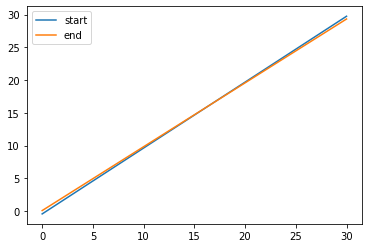

In [22]:
plt.plot(speed_130, speed_122_start, label='start')
plt.plot(speed_130, speed_122_end, label='end')
plt.legend()

In [23]:
abs_change = speed_122_end - speed_122_start
rel_change = abs_change / speed_122_start * 100

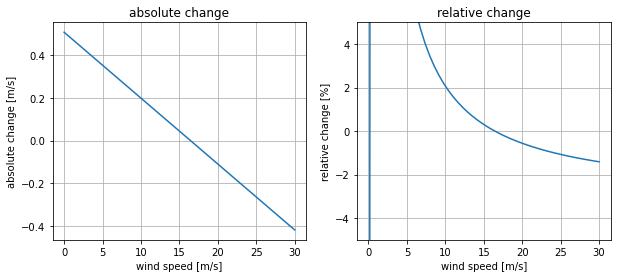

In [24]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(10,4))
axs[0].plot(speed_130, abs_change)
axs[0].set_title('absolute change')
axs[0].set_xlabel('wind speed [m/s]')
axs[0].set_ylabel('absolute change [m/s]')
axs[0].grid()

axs[1].plot(speed_130, rel_change)
axs[1].set_ylim(-5,5)
axs[1].set_title('relative change')
axs[1].set_xlabel('wind speed [m/s]')
axs[1].set_ylabel('relative change [%]')
axs[1].grid()

Change depends on wind speed. What are normal speeds?

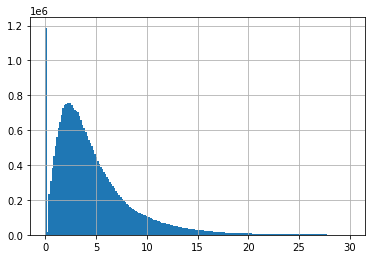

In [25]:
onehz['Cup_WS_C1_130m'].hist(bins=200, range=(0,30))

Uh-oh, lots of low speeds where difference is large. What is distribution-weighted change?

In [26]:
diff_coeffs = end_coeffs - start_coeffs
diff = onehz['Cup_WS_C1_130m'] * diff_coeffs['slope'] + diff_coeffs['intercept']
print(f'mean bias [m/s]: {diff.mean():.3f} m/s\nmean bias [%]: {diff.mean() / onehz["Cup_WS_C1_130m"].mean() * 100:.1f} %')
del diff # memory

mean bias [m/s]: 0.365 m/s
mean bias [%]: 7.8 %


Yikes! Sensor drift is typically about 0.5% per year, not 8%. Thankfully the 122m instrument was only included to help detect other problems, so I won't take any steps to mitigate this. But I need to keep this in mind when using it as a reference.

After seeing the sonic anemometers, I thought there would be lots of spikes in the cup anemometer data. But there were only a handful of clear single-point anomalies. There were another 20 or so ambiguous events characterized by a sharp change immediately followed by a short decay process (such as the 2nd and 3rd to last plots above). I left those in but have no idea what they are.

* ~~dead instruments - long periods of 0s~~
* ~~calibration changes and sensor drift - changes in linear correlation structure between related sensors~~
* ~~data logger errors and electrical interference - spikes and out-of-range values~~

## ice buildup - flatlines
![anemometer with icing](../reports/figures/anemometer_ice.jpg)
Freezing fog and rain can completely stop cup anemometers from rotating, leading to hours or days of false zero values until the ice melts. Even partially iced sensors produce subtler errors due to aerodynamic changes. Detecting subtle effects, and differentiating true zero values from short-duration icing artifacts, can be impossible without redundant reference sensors less susceptible to ice buildup. I'll use a nearby sonic anemometer for help with this.

In [27]:
def is_dense_zeros(series: pd.Series, window_seconds=7200, threshold_frac=0.9):
    """find windows with at least threshold_frac zero values.
    A 2-hour window is default because icing events usually last at least this long, whereas true zero speed events are usually much shorter.
    
    This will label a 'false' positive buffer on either side of each event of length (1 - threshold_frac) * window_seconds.
    For ice detection, these are not really false positives, because ice takes time to accrete/melt before/after it gets thick enough to completely freeze a sensor.
    This 'partial icing' interferes with sensor readings and should be removed anyway. The boundaries are ambiguous without more information."""
    mostly_zeros = series.eq(0).rolling(f'{window_seconds}s').mean().ge(threshold_frac)
    # need to label all the points within the window, not just the leading edge.
    edges = mostly_zeros ^ mostly_zeros.shift(-1)
    indices = series.index[edges]
    fill = np.full(window_seconds+1, True)
    window_delta = pd.Timedelta(window_seconds, unit='seconds')
    
    for idx in indices:
        mostly_zeros.loc[idx - window_delta: idx] = fill
    return mostly_zeros

In [28]:
flags = is_dense_zeros(onehz['Cup_WS_C1_130m'])
flags.sum()

1003268

In [29]:
def convert_flags_to_events(bool_series: pd.Series) -> pd.DataFrame:
    """pick out start and stop times of contiguous flag periods using rolling XOR.
    Input series must have DatetimeIndex with no missing values"""
    edges = bool_series.index[bool_series ^ bool_series.shift(-1)] # lagged XOR picks out changepoints       
    
    # changepoints alternate between starting and ending points of each period
    evens = edges[::2]
    odds = edges[1::2]
    
    start_with_flag = bool_series.iloc[0]
    end_with_flag = bool_series.iloc[-1]
    
    out_dict = {}
    if start_with_flag: # first changepoint marks the END of an event
        out_dict["start"] = pd.concat([bool_series.index[0], odds]) # add start point at first timestamp
        if end_with_flag:
            out_dict["end"] = pd.concat([evens, bool_series.index[-1]]) # add end point at last timestamp
        else: 
            out_dict["end"] = evens
    
    else: # first changepoint marks the START of an event, so switch even/odd
        out_dict["start"] = evens
        if end_with_flag:
            out_dict["end"] = pd.concat([odds, bool_series.index[-1]]) # add end point at last timestamp
        else: 
            out_dict["end"] = odds
            
    return pd.DataFrame(out_dict)

In [30]:
icing = convert_flags_to_events(flags)
icing.shape

(12, 2)

In [31]:
icing['duration'] = icing['end'] - icing['start']
icing

,start,end,duration
0,2019-02-06 14:41:59,2019-02-06 17:56:42,0 days 03:14:43
1,2019-02-06 23:06:52,2019-02-07 09:18:42,0 days 10:11:50
2,2019-02-27 17:42:36,2019-02-27 23:41:23,0 days 05:58:47
3,2019-04-10 10:58:04,2019-04-11 08:49:22,0 days 21:51:18
4,2019-05-09 17:53:46,2019-05-10 05:26:37,0 days 11:32:51
5,2019-05-20 04:36:36,2019-05-20 11:19:03,0 days 06:42:27
6,2019-10-10 00:29:26,2019-10-11 09:19:58,1 days 08:50:32
7,2019-10-27 02:46:10,2019-10-30 22:02:19,3 days 19:16:09
8,2019-11-06 18:57:24,2019-11-07 10:55:05,0 days 15:57:41
9,2019-11-11 02:06:24,2019-11-12 04:54:13,1 days 02:47:49


Next, to reduce false positives, I'll filter the icing events by weather conditions that can plausibly produce icing.

* tempertature < 1 degree (not zero due to differences between air temp and anemometer surface temp)
* dew point > (air temp - 2). These are high humidity times when frost and freezing rain/fog can occur.

In [32]:
onehz['temp_122m'] = onehz['Air_Temp_87m'] + onehz['DeltaT_122_87m']
onehz['dew_diff'] = onehz['temp_122m'] - onehz['Dewpt_Temp_122m']

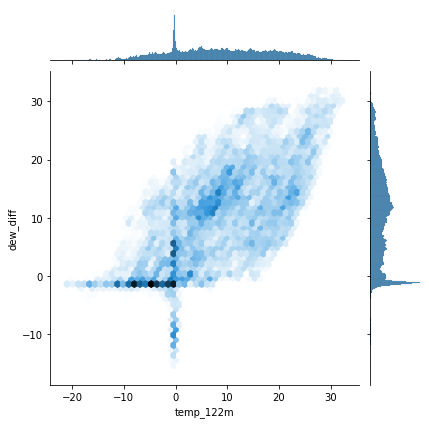

In [33]:
sns.jointplot(data=onehz, x='temp_122m', y='dew_diff', kind='hex')

In [34]:
icing['start_temp'] = 0.0
icing['start_dew_diff'] = 0.0
for i, idx in enumerate(icing['start'].values):
    icing.at[i, 'start_temp'] = onehz.at[idx, 'temp_122m']
    icing.at[i, 'start_dew_diff'] = onehz.at[idx, 'dew_diff']
icing

,start,end,duration,start_temp,start_dew_diff
0,2019-02-06 14:41:59,2019-02-06 17:56:42,0 days 03:14:43,-11.885758,-1.555550
1,2019-02-06 23:06:52,2019-02-07 09:18:42,0 days 10:11:50,-19.901037,-1.664278
2,2019-02-27 17:42:36,2019-02-27 23:41:23,0 days 05:58:47,-5.745035,0.099602
3,2019-04-10 10:58:04,2019-04-11 08:49:22,0 days 21:51:18,-0.500176,-1.244333
4,2019-05-09 17:53:46,2019-05-10 05:26:37,0 days 11:32:51,-0.696930,0.006500
5,2019-05-20 04:36:36,2019-05-20 11:19:03,0 days 06:42:27,-0.454761,-1.108038
6,2019-10-10 00:29:26,2019-10-11 09:19:58,1 days 08:50:32,-4.965569,-1.126782
7,2019-10-27 02:46:10,2019-10-30 22:02:19,3 days 19:16:09,-5.133189,-1.164573
8,2019-11-06 18:57:24,2019-11-07 10:55:05,0 days 15:57:41,-3.334186,-1.488266
9,2019-11-11 02:06:24,2019-11-12 04:54:13,1 days 02:47:49,-9.973657,-0.824886


In [35]:
# no filtering required
((icing['start_temp'] < 1) & (icing['start_dew_diff'] < 2)).all()

True

In [36]:
def plot_event_period(data_df, event_df, idx_n, figsize=(20,9), **kwargs):
    vanes = ['Vane_WD_122m', 'Vane_WD_87m']
    anemometers = ['Cup_WS_C1_130m', 'Cup_WS_C1_105m']
    buffer = event_df.loc[idx_n, 'duration'] / 4
    start = event_df.loc[idx_n, 'start'] - buffer
    end = event_df.loc[idx_n, 'end'] + buffer
    downsample = data_df.loc[start:end, vanes + anemometers].resample('10min').mean()
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=figsize, **kwargs)
    for i, instr in enumerate([vanes, anemometers]):
        downsample[instr].plot(ax=axs[i])
    plt.show()

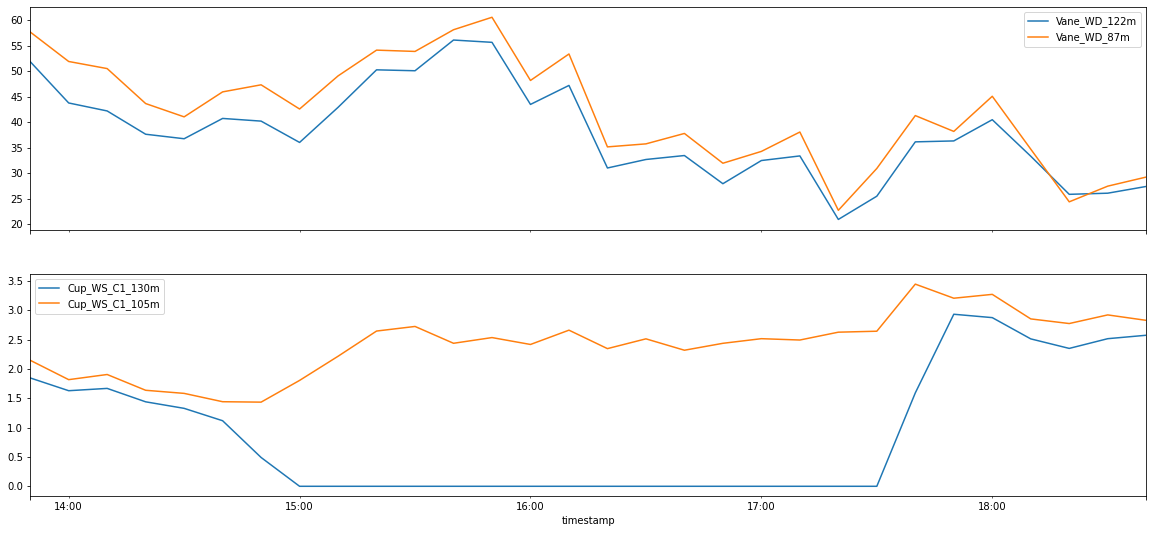

In [37]:
plot_event_period(onehz, icing, 0)

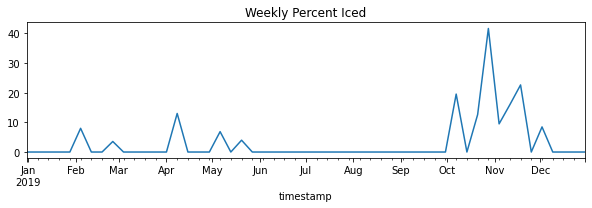

In [38]:
plt.figure(figsize = (10,2.5))
ax = flags.resample('7d').mean().mul(100).plot()
ax.set_title('Weekly Percent Iced')
plt.show()

I'll assume that when one instrument is frozen, the other one has some ice buildup and should be discarded as well.

In [39]:
combined_flags = is_dense_zeros(onehz['Cup_WS_C1_130m']) | is_dense_zeros(onehz['Cup_WS_C1_105m'])

Time to make some labels

In [83]:
# data structure is:
# {column : DataFrame(columns = label_type, values = indices)}
# This way I can keep track of different causes but also easily combine them all with df.any(axis=1)
labels = {'Cup_WS_C1_130m' : pd.DataFrame({'icing' : combined_flags}, index=onehz.index),
          'Cup_WS_C1_105m' : pd.DataFrame({'icing' : combined_flags}, index=onehz.index)
         }

* ~~dead instruments - long periods of 0s~~
* ~~calibration changes and sensor drift - changes in linear correlation structure between related sensors~~

## data logger errors and electrical interference - spikes and out-of-range values
This stage of validation deals with individual data points, so downsampled aggregates won't work and the data volume is too high to do much direct visualization.
I'll start with the easy part:
### Fixed range validation

In [41]:
plausible = pd.DataFrame({'Air_Temp_87m' : [-30, 50],
                          'DeltaT_122_87m' : [-20, 20],
                          'Dewpt_Temp_122m' : [-30, 50],
                          'Dewpt_Temp_87m' : [-30, 50],
                          'PRECIP_INTEN' : [0, 3.05],
                          'Cup_WS_C1_130m' : [0, 50],
                          'Cup_WS_122m' : [0, 50],
                          'Cup_WS_C1_105m' : [0, 50],
                          'Vane_WD_122m' : [0, 360],
                          'Vane_WD_87m' : [0, 360],
                         },
                        index = ['min', 'max'])
plausible.T

,min,max
Air_Temp_87m,-30.0,50.00
DeltaT_122_87m,-20.0,20.00
Dewpt_Temp_122m,-30.0,50.00
Dewpt_Temp_87m,-30.0,50.00
PRECIP_INTEN,0.0,3.05
Cup_WS_C1_130m,0.0,50.00
Cup_WS_122m,0.0,50.00
Cup_WS_C1_105m,0.0,50.00
Vane_WD_122m,0.0,360.00
Vane_WD_87m,0.0,360.00


In [42]:
# plausible min - observed min should be <=0
# plausible max - observed max should be >=0
observed = onehz.agg(['min', 'max'])
diff = plausible - observed
pd.concat([(diff.loc['min',:] <= 0), (diff.loc['max',:] >= 0)], axis=1)

,min,max
Air_Temp_87m,True,True
Cup_WS_122m,True,False
Cup_WS_C1_105m,True,True
Cup_WS_C1_130m,True,True
DeltaT_122_87m,True,True
Dewpt_Temp_122m,True,True
Dewpt_Temp_87m,True,True
PRECIP_INTEN,True,True
Vane_WD_122m,True,True
Vane_WD_87m,True,True


In [43]:
observed.T

,min,max
Air_Temp_87m,-21.236944,33.151836
DeltaT_122_87m,-7.123314,9.393590
Dewpt_Temp_122m,-21.794058,35.466793
Dewpt_Temp_87m,-21.269390,26.257153
PRECIP_INTEN,0.871103,3.024838
Cup_WS_C1_130m,0.000000,41.961575
Cup_WS_122m,0.000000,4349.261230
Cup_WS_C1_105m,0.000000,44.628307
Vane_WD_122m,0.015585,359.992828
Vane_WD_87m,0.005312,359.997467


4349 m/s is clearly an erroneous value for Cup_WS_122m. Time to add some data labels.

In [86]:
labels['Cup_WS_122m'] = pd.DataFrame({'out_of_range': onehz['Cup_WS_122m'] > 50}, index=onehz.index)

In [87]:
# only 4 points were erroneous, but were WAY out
labels['Cup_WS_122m']['out_of_range'].sum()

4

### Spike detection

Before I can do spike detection, I first have to deal with a weird processing artifact from NREL.

Cup anemometers have a lower limit of sensitivity - very low wind speeds aren't strong enough to overcome the friction in the sensor. Due to the linear transfer function, these 0-rpm values normally get recorded at the transfer function intercept.

But NREL does a weird processing thing where they clip all those values and send them to zero, as shown in the histogram below.

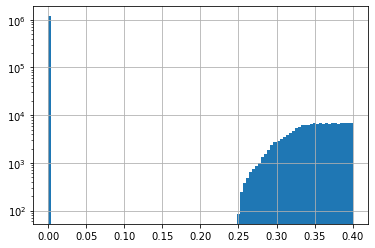

In [46]:
# clipping between 0 and 0.25
onehz['Cup_WS_C1_130m'].hist(bins=100, range=(0,0.4), log=True)

The problem is that values *juuust* above that threshold are left alone, creating false spikes that appear in my spike detector by the hundreds. This could be solved by labeling data and making a classifier, but in this dataset there are so few true positives (less than 10) that it's easier to just tinker by hand.

In [47]:
def remove_floor_spikes(series, window_seconds=9, thresh=4):
    """make an indicator series: 1 where at least 'thresh' values are nonzero, 0 elsewhere.
    Then multiply input series by indicator series (map failures to 0)"""
    not_zero = series != 0
    keep = not_zero.rolling(f'{window_seconds}s').sum().shift(-1 * int(window_seconds / 2)) >= thresh
    return series.mul(keep)

Spikes UP from the floor are the issue. Spikes DOWN to zero are fine because I will simply replace all 0 values with NaN in the next step.

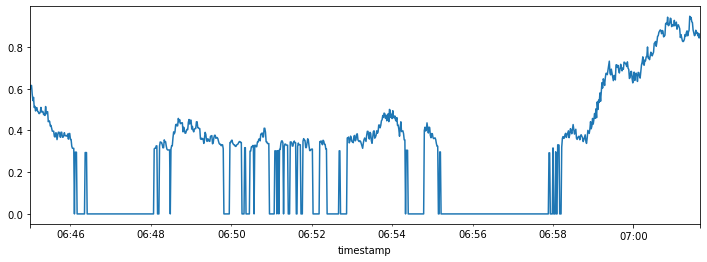

In [48]:
test = onehz.iloc[49500:50500, 5]
test.plot(figsize=(12,4))

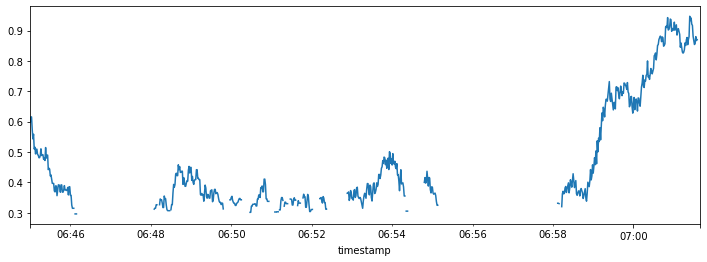

In [49]:
remove_floor_spikes(test, window_seconds=9, thresh=4).replace(0, np.nan).plot(figsize=(12,4))

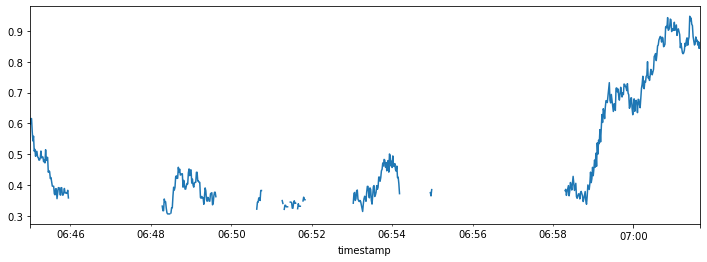

In [50]:
test.where(~is_dense_zeros(test, window_seconds=15, threshold_frac=0.4)).replace(0, np.nan).plot(figsize=(12,4))

In [51]:
def spike_score(series, low_pass_window_seconds=25, norm_window_seconds=60*4):
    """compute distance from low-pass trend (centered rolling median).
    Normalize by local standard deviation of those distances. The two rolling operations need different sizes.
    The last few points in the series are NOT scored! Check manually"""
    series = series.where(~is_dense_zeros(series, window_seconds=15, threshold_frac=0.4)).replace(0, np.nan)
    low_pass = series.rolling(f'{low_pass_window_seconds}s').median().shift(-1 * int(low_pass_window_seconds / 2), freq='s')
    diff = series.sub(low_pass)
    norm = diff.rolling(f'{norm_window_seconds}s').std().shift(-1 * int(norm_window_seconds / 2), freq='s')
    return diff.div(norm).loc[series.index[0]:series.index[-1]]

In [52]:
spike_normed = spike_score(onehz['Cup_WS_C1_130m'])

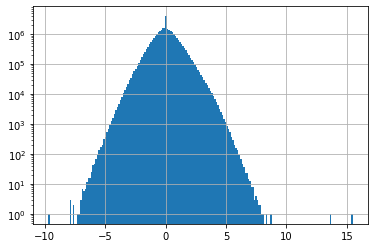

In [53]:
spike_normed.hist(bins=200, log=True)

In [54]:
bot_spike_normed = spike_normed.nsmallest(20)

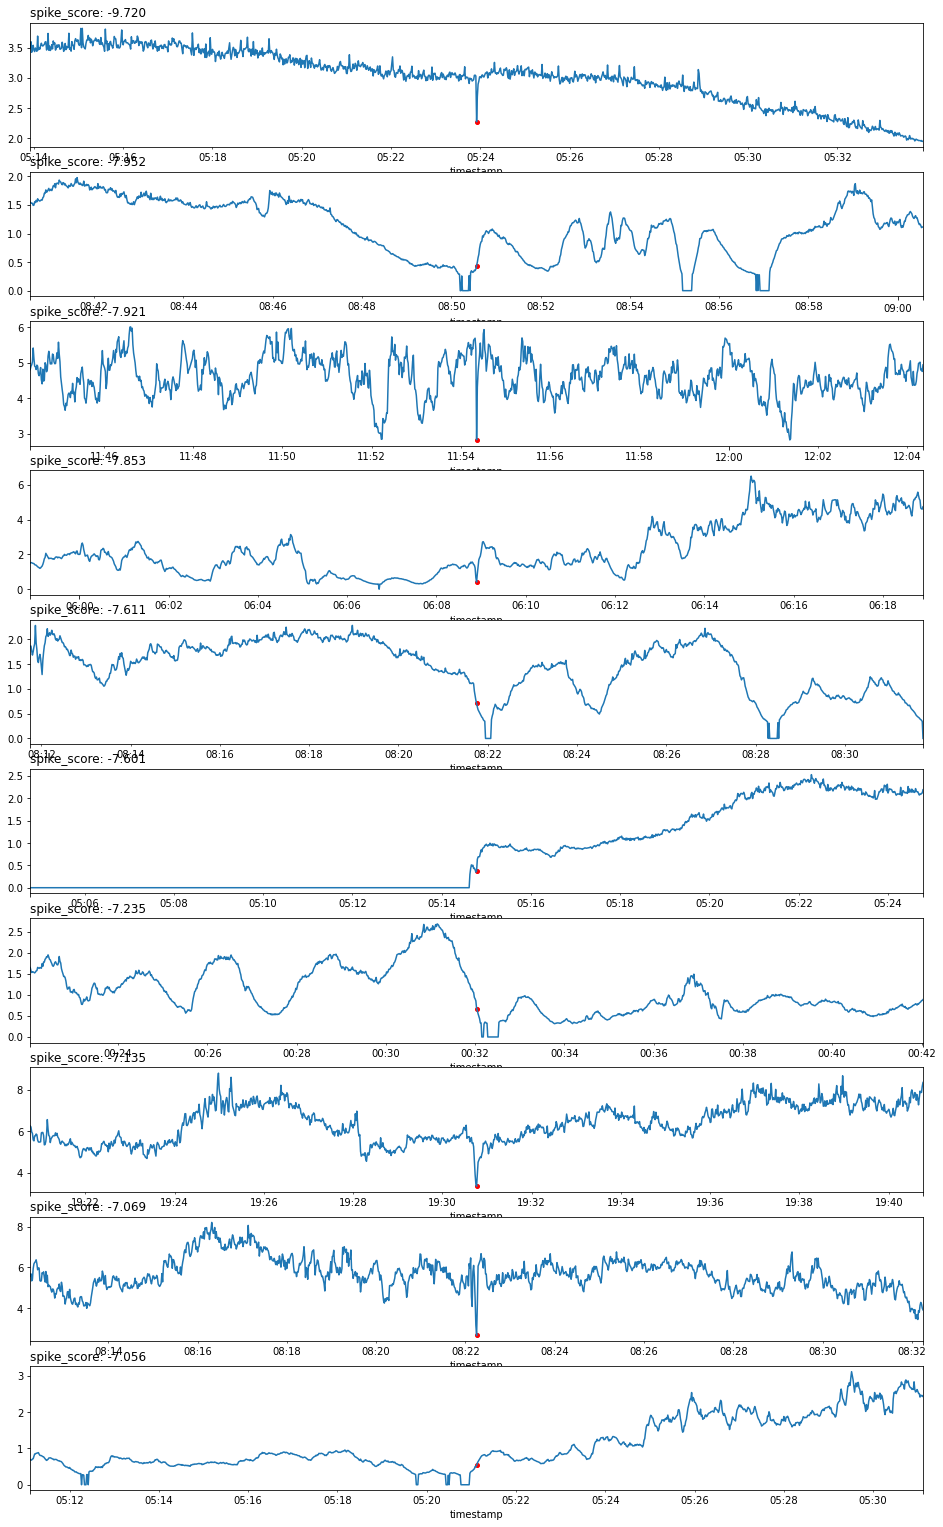

In [55]:
fig, axs = plt.subplots(nrows=10, figsize=(16,27))
for i, ts in enumerate(bot_spike_normed.iloc[0:10].index):
    start = ts - pd.Timedelta('10min')
    end = ts + pd.Timedelta('10min')
    onehz.loc[start:end, 'Cup_WS_C1_130m'].plot(ax=axs[i])
    axs[i].scatter(ts, onehz.at[ts, 'Cup_WS_C1_130m'], c='red', s=16)
    axs[i].set_title(f'spike_score: {bot_spike_normed[ts]:.3f}', loc='left')
plt.show()

In [56]:
top_spike_normed = spike_normed.nlargest(20)

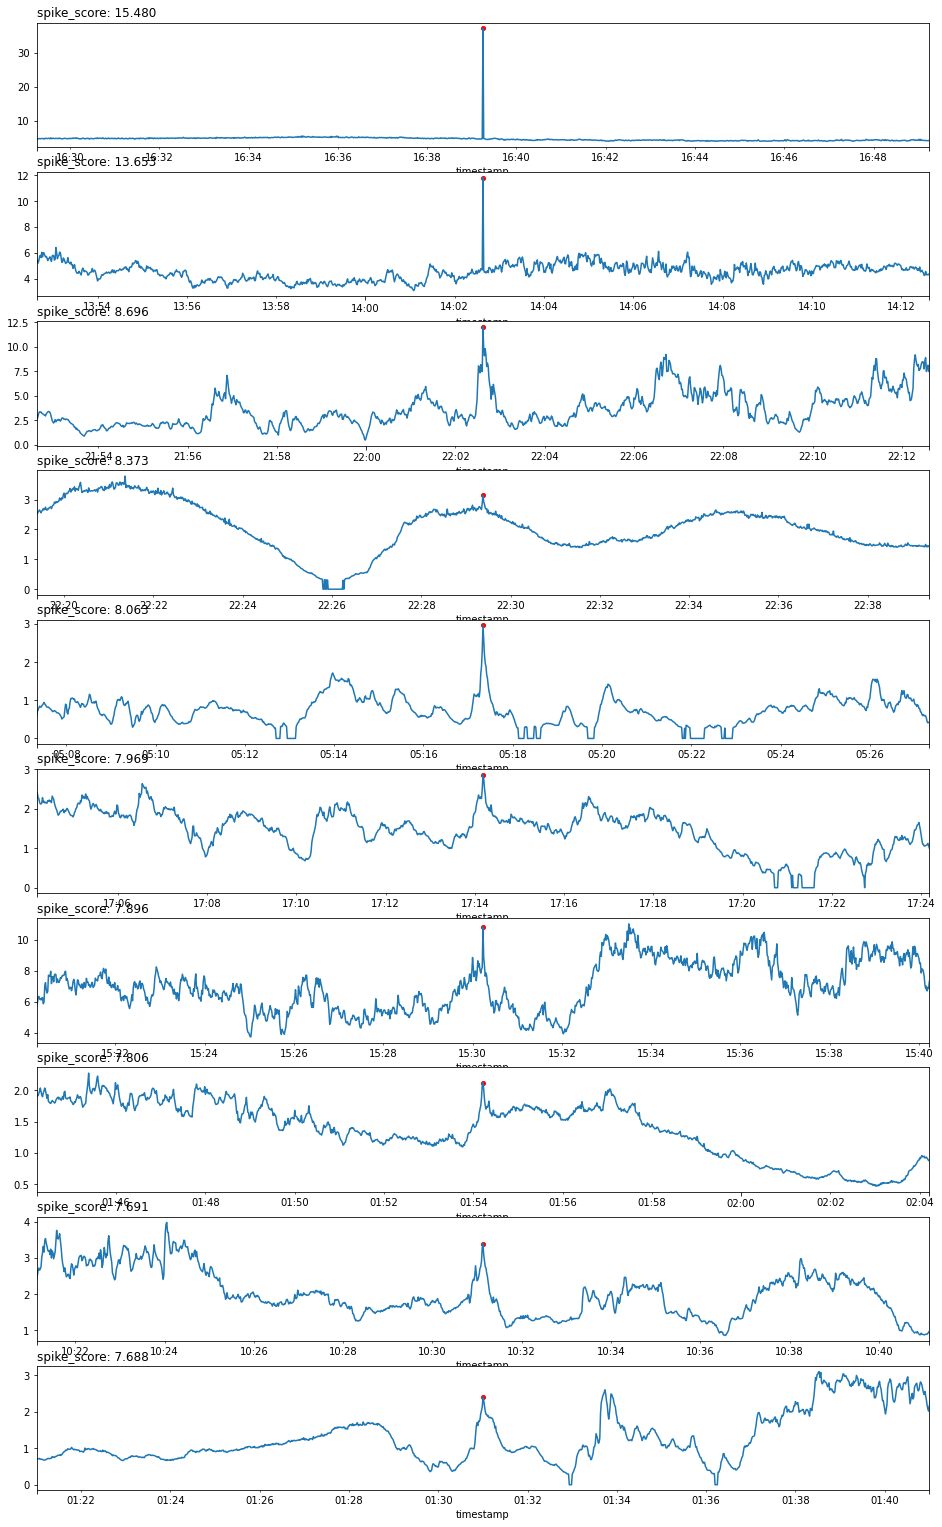

In [57]:
fig, axs = plt.subplots(nrows=10, figsize=(16,27))
for i, ts in enumerate(top_spike_normed.iloc[0:10].index):
    start = ts - pd.Timedelta('10min')
    end = ts + pd.Timedelta('10min')
    onehz.loc[start:end, 'Cup_WS_C1_130m'].plot(ax=axs[i])
    axs[i].scatter(ts, onehz.at[ts, 'Cup_WS_C1_130m'], c='red', s=16)
    axs[i].set_title(f'spike_score: {top_spike_normed[ts]:.3f}', loc='left')
plt.show()

In [88]:
for instr in ['Cup_WS_C1_130m', 'Cup_WS_C1_105m']:
    labels[instr]['spike'] = spike_score(onehz[instr]).abs() > 8.9                   

In [91]:
{col: df['spike'].sum() for col, df in labels.items() if 'spike' in df.columns}

{'Cup_WS_C1_130m': 3, 'Cup_WS_C1_105m': 4}

* ~~dead instruments - long periods of 0s~~
* ~~calibration changes and sensor drift - changes in linear correlation structure between related sensors~~
* ~~data logger errors and electrical interference - spikes and out-of-range values~~
* ~~ice buildup - flatlines~~

## Mast Shadow - aerodynamic interference from support structure
This one is straightforward. There is large tower holding up the instruments. When wind hits the tower before passing through the instruments, it slows down considerably (30% or more) and flutters like a flag (high frequency artifacts). So I have to remove wind speeds based on simple geometry.
![mast](../references/mast.png)
![boom diagram](../references/boom_diagram.png)

Note: the boom length is shorter for cup anemometers (only 109" instead of 251").

right triangle with sides:
* adjacent: boom + half-face-width = 109 + 20.5 = 129.5
* opposite: bisection of 41" equilateral triangle = sqrt(41^2 - 20.5^2) = 35.5

angle is inverse tangent of opp/adj

In [60]:
angle = np.arctan(35.5/129.5) * 180 / np.pi
angle

15.329966184339446

In [61]:
buffer = 5 # wind vanes are not very accurate
exclusion_limits = {'lower': 278 - 180 - buffer,
                    'upper': 278 - 180 + angle + buffer}
exclusion_limits

{'lower': 93, 'upper': 118.32996618433944}

I'll use the nearest vane height for labelling, which happens to be 122m for both 130m and 105m.

In [ ]:
direction_exclusions = ((onehz['Vane_WD_122m'] > exclusion_limits['lower'])
                        & (onehz['Vane_WD_122m'] < exclusion_limits['upper'])
                       )

In [88]:
for instr in ['Cup_WS_C1_130m', 'Cup_WS_C1_105m']:
    labels[instr]['mast_shadow'] = direction_exclusions

In [94]:
for col, label_df in labels.items():
    filepath = data_path.parent / "labels" / f"{col}_labels.parquet.gz"
    label_df.to_parquet(filepath, compression='gzip')